# Word Level Federated Text Generation with Stack Overflow with Randomly Initialized or Pretrained Word Embeddings
- Joel Stremmel
- 02-19-20
- Runs on GCP and local Ubuntu 16.04

**About:**

This notebook loads the Stack Overflow data available through `tff.simulation.datasets` and trains an LSTM model with Federared Averaging by following the Federated Learning for Text Generation [example notebook](https://github.com/tensorflow/federated/blob/master/docs/tutorials/federated_learning_for_text_generation.ipynb).  The embedding layer is optionally initialized with [GloVe](https://nlp.stanford.edu/projects/glove/) ([license here](https://www.opendatacommons.org/licenses/pddl/1.0/)), [FastText](https://fasttext.cc/docs/en/english-vectors.html) ([license here](https://creativecommons.org/licenses/by-sa/3.0/)), [GPT-2](https://openai.com/blog/better-language-models/) ([license here](https://github.com/huggingface/transformers/blob/master/LICENSE)), or randomly initialized embeddings.  After downloading the GloVe or FastText embeddings, place the embedding files in a directory called `word_embedding` at the top level of the repository.  GPT-2 embeddings are downloaded by running the notebook which makes a call to `src/embeddings.py` to download the embeddings from HuggingFace.  For more information on downloading or using these embeddings, see the research report.

**Notes:**

- This notebook prepares the Stack Overflow dataset for word level language modeling using this [module](https://github.com/tensorflow/federated/blob/master/tensorflow_federated/python/research/baselines/stackoverflow/dataset.py
).
- The metrics for model training come from this [module](https://github.com/tensorflow/federated/blob/master/tensorflow_federated/python/research/baselines/stackoverflow/metrics.py). 


**Data and Model References:**
- [TFF Stack Overflow `load_data`](https://www.tensorflow.org/federated/api_docs/python/tff/simulation/datasets/stackoverflow/load_data)
- [TFF text generation tutorial](https://github.com/tensorflow/federated/blob/master/docs/tutorials/federated_learning_for_text_generation.ipynb)
- [Google TFF team research baselines for Stack Overflow](https://github.com/tensorflow/federated/tree/master/tensorflow_federated/python/research/baselines/stackoverflow)
- [Tensorflow text generation tutorial](https://www.tensorflow.org/tutorials/text/text_generation)

**Environment Setup References:**
- [Installing Tensorflow for GPU](https://www.tensorflow.org/install/gpu)
- [Install CUDA 10.0 and cuDNN v7.4.2 on Ubuntu 16.04](https://gist.github.com/matheustguimaraes/43e0b65aa534db4df2918f835b9b361d)
- [Tensorflow build configs](https://www.tensorflow.org/install/source#tested_build_configurations)
- [Using jupyter notebooks with a virtual environment](https://anbasile.github.io/programming/2017/06/25/jupyter-venv/)

### Imports

In [1]:
import nest_asyncio
nest_asyncio.apply()

In [2]:
import os, sys, io
sys.path.append(os.path.dirname(os.getcwd()))

In [3]:
import collections
import functools
import six
import time
import string

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_federated as tff

In [4]:
from src import dataset, metrics, embeddings, model, validation, federated, generate_text

In [5]:
# word2idx = {'hello': 0, 'my': 1, 'darling': 2, 'gobdobdob': 3}
# embedding_index = embeddings.create_gpt_embeddings(word2idx)
# reduced_embedding_index = embeddings.to_pca_projection(embedding_index, n=2)

### Set Compatability Behavior

In [6]:
tf.compat.v1.enable_v2_behavior()

### Check Tensorflow Install

In [7]:
print('Built with Cuda: {}'.format(tf.test.is_built_with_cuda()))
print('Build with GPU support: {}'.format(tf.test.is_built_with_gpu_support()))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Built with Cuda: True
Build with GPU support: True
Num GPUs Available:  0


### Test TFF

In [8]:
tff.federated_computation(lambda: 'Hello, World!')()

b'Hello, World!'

### Set Some Parameters for Preprocessing the Data and Training the Model

In [9]:
VOCAB_SIZE = 10000
BATCH_SIZE = 8
CLIENTS_EPOCHS_PER_ROUND = 1
MAX_SEQ_LENGTH = 20
MAX_ELEMENTS_PER_USER = 5000
CENTRALIZED_TRAIN = False
SHUFFLE_BUFFER_SIZE = 1000
NUM_VALIDATION_EXAMPLES = 10000
NUM_TEST_EXAMPLES = 2

NUM_ROUNDS = 10
NUM_TRAIN_CLIENTS = 10

EMBEDDING_DIM = 100
RNN_UNITS = 256

EMBEDDING_LAYER = 'glove'
SAV = 'embedding_layer_results/{}_{}_{}_{}/'.format(EMBEDDING_LAYER, 
                                                    EMBEDDING_DIM, 
                                                    RNN_UNITS, 
                                                    EMBEDDING_DIM)

### Create the Output Directory if it Nonexistent

In [10]:
if not os.path.exists(SAV):
    os.makedirs(SAV)

### Load and Preprocess Word Level Datasets

In [11]:
train_data, val_data, test_data = dataset.construct_word_level_datasets(
    vocab_size=VOCAB_SIZE,
    batch_size=BATCH_SIZE,
    client_epochs_per_round=CLIENTS_EPOCHS_PER_ROUND,
    max_seq_len=MAX_SEQ_LENGTH,
    max_elements_per_user=MAX_ELEMENTS_PER_USER,
    centralized_train=CENTRALIZED_TRAIN,
    shuffle_buffer_size=SHUFFLE_BUFFER_SIZE,
    num_validation_examples=NUM_VALIDATION_EXAMPLES,
    num_test_examples=NUM_TEST_EXAMPLES)

/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


### Retrieve the Dataset Vocab

In [12]:
vocab = dataset.get_vocab(vocab_size=VOCAB_SIZE)

### Retrieve the Special Characters Created During Preprocessing
The four special tokens are:
- pad: padding token
- oov: out of vocabulary
- bos: begin of sentence
- eos: end of sentence

In [13]:
special_tokens = list(dataset.get_special_tokens(vocab_size=VOCAB_SIZE))
special_words = list(dataset.get_special_token_words())

In [14]:
special2idx = dict(zip(special_tokens, special_words))
idx2special = {v:k for k, v in special2idx.items()}

### Set Vocabulary
Add one to account for the pad token which has idx 0.

In [15]:
word2idx = {word:i+1 for i, word in enumerate(vocab)}
idx2word = {i+1:word for i, word in enumerate(vocab)}

### Add Special Characters

In [16]:
word2idx = {**word2idx, **special2idx}
idx2word = {**idx2word, **idx2special}

### Reset Vocab Size
This accounts for having added the special characters.

In [17]:
EXTENDED_VOCAB_SIZE = VOCAB_SIZE + len(special2idx)

### Load Pretrained Word Embeddings
- Either [GloVe embeddings from Stanford](https://nlp.stanford.edu/projects/glove/) - license [here](https://www.opendatacommons.org/licenses/pddl/1.0/)
- [FastText embeddings from Facebook](https://fasttext.cc/docs/en/english-vectors.html) - license [here](https://creativecommons.org/licenses/by-sa/3.0/)
- Or word embeddings from [OpenAI GPT-2](https://openai.com/blog/better-language-models/) - license [here](https://github.com/huggingface/transformers/blob/master/LICENSE)

### Create Embedding Matrix from Words in Word Index and Word Embeddings
If the `EMBEDDING_LAYER` option is set to 'random', the embedding matrix in the embedding layer is initialized according to the random uniform distribution used by the tf.keras embedding layer by passing the 'uniform' string as an argument to the `embedding_initializer` in the `build_model` function.  Otherwise, an embedding index called `word2embedding` is created from pretrained embeddings either loaded from the 'word_embeddings' directory or created from a pretrained model.

In [18]:
if EMBEDDING_LAYER == 'random':
    pass

elif EMBEDDING_LAYER == 'glove':
    embedding_path = '../word_embeddings/glove/glove.6B.{}d.txt'.format(EMBEDDING_DIM)
    word2embedding = embeddings.load_embeddings(embedding_path)
    
elif EMBEDDING_LAYER == 'fasttext':
    embedding_path = '../word_embeddings/fasttext/wiki-news-{}d-1M.vec'.format(EMBEDDING_DIM)
    word2embedding = embeddings.load_embeddings(embedding_path)
    
elif EMBEDDING_LAYER == 'gpt2':
    word2embedding = embeddings.create_gpt_embeddings(word2idx)
    word2embedding = embeddings.to_pca_projections(word2embedding, n=2)
    
else:
    raise ValueError("EMBEDDING LAYER must be one of 'random', 'glove', 'fasttext', or 'gpt2'.")

In [19]:
if EMBEDDING_LAYER == 'random':
    embedding_matrix = 'uniform'
else:
    embedding_matrix = embeddings.create_matrix_from_pretrained_embeddings(
        word2embedding=word2embedding,
        embedding_dim=EMBEDDING_DIM,
        word2idx=word2idx)

/home/joel_stremmel/Documents/dev_gear/git/fl-text-models/src/embeddings.py:79: missing_words_warning: 1307 words set to default random initialization
  .format(missing), missing_words_warning)


In [20]:
keras_model = model.build_model(extended_vocab_size=EXTENDED_VOCAB_SIZE,
                                embedding_dim=EMBEDDING_DIM,
                                embedding_matrix=embedding_matrix,
                                rnn_units=RNN_UNITS)

### Load or Build the Model and Try Generating Some Text

In [21]:
keras_model = model.build_model(extended_vocab_size=EXTENDED_VOCAB_SIZE,
                                embedding_dim=EMBEDDING_DIM,
                                embedding_matrix=embedding_matrix,
                                rnn_units=RNN_UNITS)

generate_text.generate_text(model=keras_model,
                            word2idx=word2idx,
                            idx2word=idx2word,
                            start_string='How are you today')

"how are you today gotta start_date listeners important obvious caret holes evident culture eat pem querystring symmetric marshalling benefits 456 ssl navigation slot artifacts b's pattern rebuilding prepend nameerror matt concatenate honest putty iptables meet conditions fade mousemove it's 405 sole construct ping packet forbid pulls minify fullscreen reusable license viewer dictates refreshed weight"

### Create TFF Version of the Model to be Trained with Federated Averaging
- TFF uses a sample batch so it knows the types and shapes that your model expects.
- The model function then builds and compiles the model and creates a TFF version to be trained.

In [22]:
sample_batch = tf.nest.map_structure(lambda x: x.numpy(), next(iter(val_data)))

/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


### Initialize Train and Validation Model Trackers to be Used Below

In [23]:
evaluation_metric_names = ['loss',
                           'num_tokens',
                           'num_tokens_no_oov',
                           'num_batches',
                           'num_examples',
                           'accuracy',
                           'accuracy_no_oov',
                           'accuracy_no_oov_no_oes']

train_metrics_tracker = validation.model_history_tracker(metric_names=evaluation_metric_names)
val_metrics_tracker = validation.model_history_tracker(metric_names=evaluation_metric_names)

### Set the Default Executor

In [24]:
tff.framework.set_default_executor(tff.framework.local_executor_factory())

### Create an Iterative Process

In [25]:
iterative_process = (
      tff.learning.federated_averaging.build_federated_averaging_process(
          model_fn=lambda : model.model_fn(extended_vocab_size=EXTENDED_VOCAB_SIZE,
                        embedding_dim=EMBEDDING_DIM,
                        embedding_matrix=embedding_matrix,
                        rnn_units=RNN_UNITS,
                        vocab_size=VOCAB_SIZE,
                        sample_batch=sample_batch),
          server_optimizer_fn=federated.server_optimizer_fn,
          client_weight_fn=federated.client_weight_fn))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/learning/federated_averaging.py:242: UserWarning: tff.learning.build_federated_averaging_process will start requiring a new argument 'client_optimizer_fn'. Specify the local client optimizer here rather than building a ttf.learning.TrainableModel
  warnings.warn('tff.learning.build_federated_averaging_process will start '
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


### Initalize the Process
Server state will be updated in the training loop.

In [26]:
server_state = iterative_process.initialize()

### Train Model Across Many Randomly Sampled Clients with Federated Averaging

Evaluating before training round #0 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 13s 128ms/step - loss: 6.3381 - num_tokens: 130602.0000 - num_tokens_no_oov: 126276.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0042 - accuracy_no_oov: 0.0043 - accuracy_no_oov_no_eos: 0.0046Sampling 10 new clients.
Round: 0
   Loss: 6.14250898
   num_batches: 418
   num_examples: 3311
   num_tokens: 46064
   num_tokens_no_oov: 44689
   accuracy: 0.00495
   accuracy_no_oov: 0.00463
Evaluating before training round #1 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 12s 124ms/step - loss: 6.6251 - num_tokens: 137416.0000 - num_tokens_no_oov: 133047.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0052 - accuracy_no_oov: 0.0053 - accuracy_no_oov_no_eos: 0.0052Sampling 10 new clients.
Round: 1
   Loss: 6.43078852
   num_batches: 287
   num_examples: 2263
   num_tokens: 29543
   num_tokens_no_oov: 28525
   accuracy: 0.00051
   accuracy_no_oov: 0.00053
Evaluating before training round #2 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 13s 125ms/step - loss: 6.5118 - num_tokens: 135188.0000 - num_tokens_no_oov: 130822.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0053 - accuracy_no_oov: 0.0054 - accuracy_no_oov_no_eos: 0.0057Sampling 10 new clients.
Round: 2
   Loss: 5.32271290
   num_batches: 411
   num_examples: 3259
   num_tokens: 42130
   num_tokens_no_oov: 40558
   accuracy: 0.01412
   accuracy_no_oov: 0.01467
Evaluating before training round #3 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 12s 124ms/step - loss: 6.5830 - num_tokens: 137611.0000 - num_tokens_no_oov: 133244.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 3.7061e-04 - accuracy_no_oov: 3.8276e-04 - accuracy_no_oov_no_eos: 3.0890e-04Sampling 10 new clients.
Round: 3
   Loss: 4.82231998
   num_batches: 798
   num_examples: 6339
   num_tokens: 88091
   num_tokens_no_oov: 85724
   accuracy: 0.05235
   accuracy_no_oov: 0.05378
Evaluating before training round #4 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 13s 125ms/step - loss: 6.2186 - num_tokens: 130784.0000 - num_tokens_no_oov: 126814.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 9.9401e-05 - accuracy_no_oov: 1.0251e-04 - accuracy_no_oov_no_eos: 5.0238e-05Sampling 10 new clients.
Round: 4
   Loss: 5.30073071
   num_batches: 358
   num_examples: 2834
   num_tokens: 35697
   num_tokens_no_oov: 34902
   accuracy: 0.00695
   accuracy_no_oov: 0.00711
Evaluating before training round #5 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 13s 125ms/step - loss: 6.0507 - num_tokens: 129668.0000 - num_tokens_no_oov: 125782.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 1.0797e-04 - accuracy_no_oov: 1.1130e-04 - accuracy_no_oov_no_eos: 8.4542e-06Sampling 10 new clients.
Round: 5
   Loss: 5.72168827
   num_batches: 269
   num_examples: 2122
   num_tokens: 27917
   num_tokens_no_oov: 27207
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #6 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 13s 125ms/step - loss: 5.7761 - num_tokens: 126797.0000 - num_tokens_no_oov: 123171.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 7.8866e-06 - accuracy_no_oov: 8.1188e-06 - accuracy_no_oov_no_eos: 8.6550e-06Sampling 10 new clients.
Round: 6
   Loss: 5.38397360
   num_batches: 382
   num_examples: 3006
   num_tokens: 41037
   num_tokens_no_oov: 39749
   accuracy: 0.00509
   accuracy_no_oov: 0.00526
Evaluating before training round #7 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 12s 124ms/step - loss: 5.7930 - num_tokens: 131332.0000 - num_tokens_no_oov: 127265.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 7.6143e-06 - accuracy_no_oov: 7.8576e-06 - accuracy_no_oov_no_eos: 8.3468e-06Sampling 10 new clients.
Round: 7
   Loss: 5.34491062
   num_batches: 251
   num_examples: 1969
   num_tokens: 25364
   num_tokens_no_oov: 24596
   accuracy: 0.00004
   accuracy_no_oov: 0.00004
Evaluating before training round #8 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 12s 123ms/step - loss: 5.6511 - num_tokens: 132221.0000 - num_tokens_no_oov: 128434.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00Sampling 10 new clients.
Round: 8
   Loss: 4.35572767
   num_batches: 834
   num_examples: 6633
   num_tokens: 91309
   num_tokens_no_oov: 89061
   accuracy: 0.09558
   accuracy_no_oov: 0.09566
Evaluating before training round #9 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


    100/Unknown - 12s 125ms/step - loss: 5.5405 - num_tokens: 133486.0000 - num_tokens_no_oov: 129324.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 7.4914e-06 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00Sampling 10 new clients.
Round: 9
   Loss: 4.28957891
   num_batches: 518
   num_examples: 4117
   num_tokens: 48261
   num_tokens_no_oov: 46818
   accuracy: 0.02080
   accuracy_no_oov: 0.02136


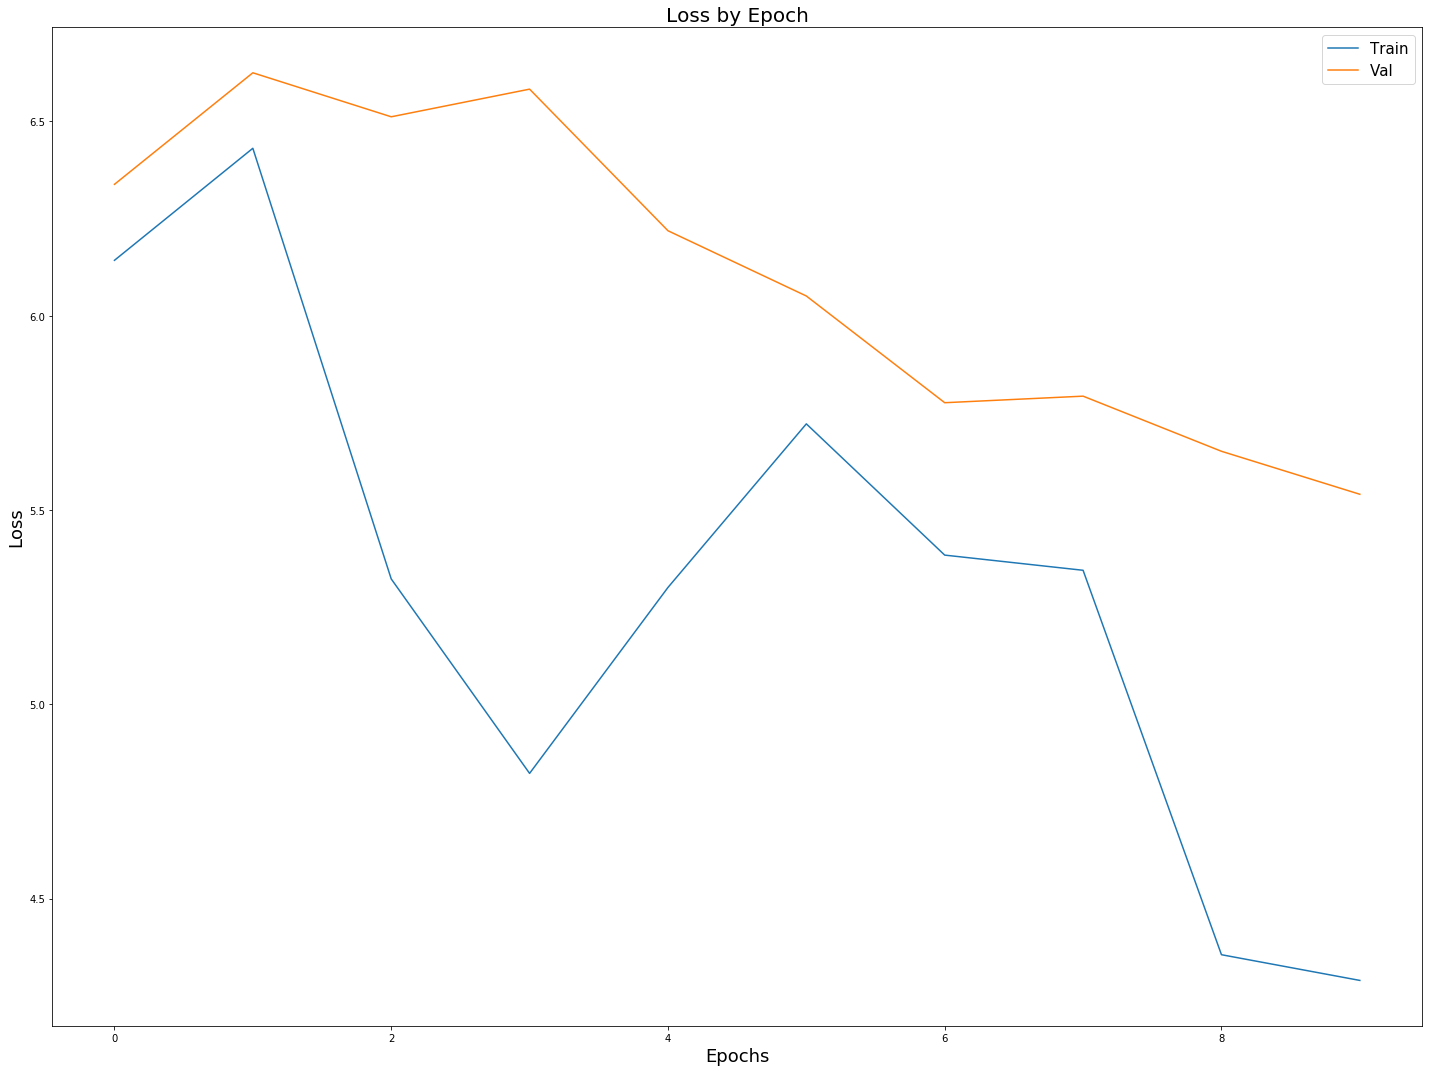

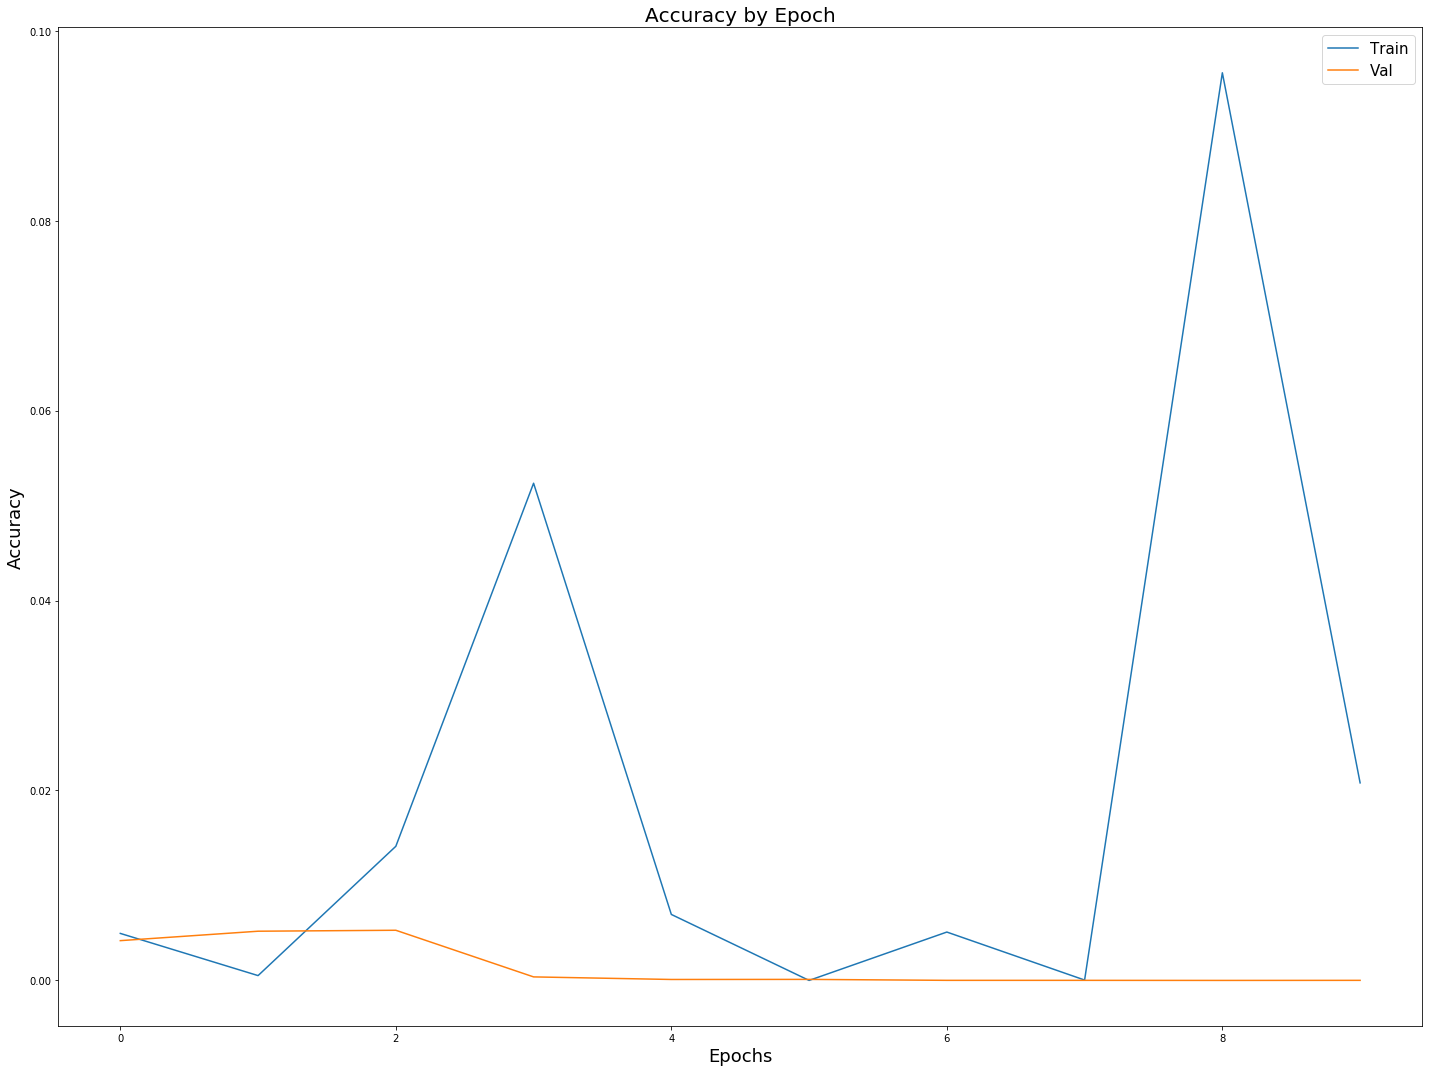

In [27]:
try:
    for round_num in range(0, NUM_ROUNDS):

        # Examine validation metrics
        print('Evaluating before training round #{} on {} examples.'.format(round_num, NUM_VALIDATION_EXAMPLES))
        validation.keras_evaluate(state=server_state,
                                  val_dataset=val_data,
                                  extended_vocab_size=EXTENDED_VOCAB_SIZE,
                                  vocab_size=VOCAB_SIZE,
                                  embedding_dim=EMBEDDING_DIM,
                                  embedding_matrix=embedding_matrix,
                                  rnn_units=RNN_UNITS,
                                  metrics_tracker=val_metrics_tracker)

        # Sample train clients to create a train dataset
        print('Sampling {} new clients.'.format(NUM_TRAIN_CLIENTS))
        train_clients = federated.get_sample_clients(dataset=train_data, num_clients=NUM_TRAIN_CLIENTS)
        train_datasets = [train_data.create_tf_dataset_for_client(client) for client in train_clients]

        # Apply federated training round
        server_state, server_metrics = iterative_process.next(server_state, train_datasets)

        # Examine training metrics
        print('Round: {}'.format(round_num))
        print('   Loss: {:.8f}'.format(server_metrics.loss))
        print('   num_batches: {}'.format(server_metrics.num_batches))
        print('   num_examples: {}'.format(server_metrics.num_examples))
        print('   num_tokens: {}'.format(server_metrics.num_tokens))
        print('   num_tokens_no_oov: {}'.format(server_metrics.num_tokens_no_oov))
        print('   accuracy: {:.5f}'.format(server_metrics.accuracy))
        print('   accuracy_no_oov: {:.5f}'.format(server_metrics.accuracy_no_oov))

        # Add train metrics to tracker
        train_metrics_tracker.add_metrics_by_name('loss', server_metrics.loss)
        train_metrics_tracker.add_metrics_by_name('accuracy', server_metrics.accuracy)
        train_metrics_tracker.add_metrics_by_name('num_examples', server_metrics.num_examples)
        train_metrics_tracker.add_metrics_by_name('num_tokens', server_metrics.num_tokens)
        train_metrics_tracker.add_metrics_by_name('num_tokens_no_oov', server_metrics.num_tokens_no_oov)
        
        # Save loss and accuracy from train and validation sets
        np.save(SAV + 'train_loss.npy', train_metrics_tracker.get_metrics_by_name('loss'))
        np.save(SAV + 'val_loss.npy', val_metrics_tracker.get_metrics_by_name('loss'))
        np.save(SAV + 'train_accuracy.npy', train_metrics_tracker.get_metrics_by_name('accuracy'))
        np.save(SAV + 'val_accuracy.npy', val_metrics_tracker.get_metrics_by_name('accuracy'))
        
        # Save train sample stats
        np.save(SAV + 'num_examples.npy', train_metrics_tracker.get_metrics_by_name('num_examples'))
        np.save(SAV + 'num_tokens.npy', train_metrics_tracker.get_metrics_by_name('num_tokens'))
        np.save(SAV + 'num_tokens_no_oov.npy', train_metrics_tracker.get_metrics_by_name('num_tokens_no_oov'))
        
except KeyboardInterrupt as ke:
    
    print('Interrupted')
    
except:
    
    import traceback
    traceback.print_exc()
    
finally:
    
    fig, ax = plt.subplots(figsize=(20, 15))
    x_axis = range(0, len(train_metrics_tracker.get_metrics_by_name('loss')))
    ax.plot(x_axis, train_metrics_tracker.get_metrics_by_name('loss'), label='Train')
    ax.plot(x_axis, val_metrics_tracker.get_metrics_by_name('loss'), label='Val')
    ax.legend(loc='best', prop={'size': 15})
    plt.title('Loss by Epoch', fontsize=20)
    plt.xlabel('Epochs', fontsize=18)
    plt.ylabel('Loss', fontsize=18)
    plt.tight_layout()
    plt.savefig(SAV + 'Loss by Epoch.png')
    plt.show()
    
    fig, ax = plt.subplots(figsize=(20, 15))
    ax.plot(x_axis, train_metrics_tracker.get_metrics_by_name('accuracy'), label='Train')
    ax.plot(x_axis, val_metrics_tracker.get_metrics_by_name('accuracy'), label='Val')
    ax.legend(loc='best', prop={'size': 15})
    plt.title('Accuracy by Epoch', fontsize=20)
    plt.xlabel('Epochs', fontsize=18)
    plt.ylabel('Accuracy', fontsize=18)
    plt.tight_layout()
    plt.savefig(SAV + 'Accuracy by Epoch.png')
    plt.show()

### Load Train Sample Stats

In [28]:
examples = np.load(SAV + 'num_examples.npy')
tokens = np.load(SAV + 'num_tokens.npy')
tokens_no_oov = np.load(SAV + 'num_tokens_no_oov.npy')

### Plot Train Sample Stats

In [29]:
round_config = 'Clients: {}, Max Elements per Client: {}, Max Seq Len: {}, Num Rounds: {}'.format(
    NUM_TRAIN_CLIENTS, MAX_ELEMENTS_PER_USER, MAX_SEQ_LENGTH, NUM_ROUNDS)

In [30]:
train_sample_stats = ['Examples', 'Tokens', 'Tokens No OOV']
means = [np.mean(examples), np.mean(tokens), np.mean(tokens_no_oov)]
stdvs = [np.std(examples), np.std(tokens), np.std(tokens_no_oov)]

<Figure size 432x288 with 0 Axes>

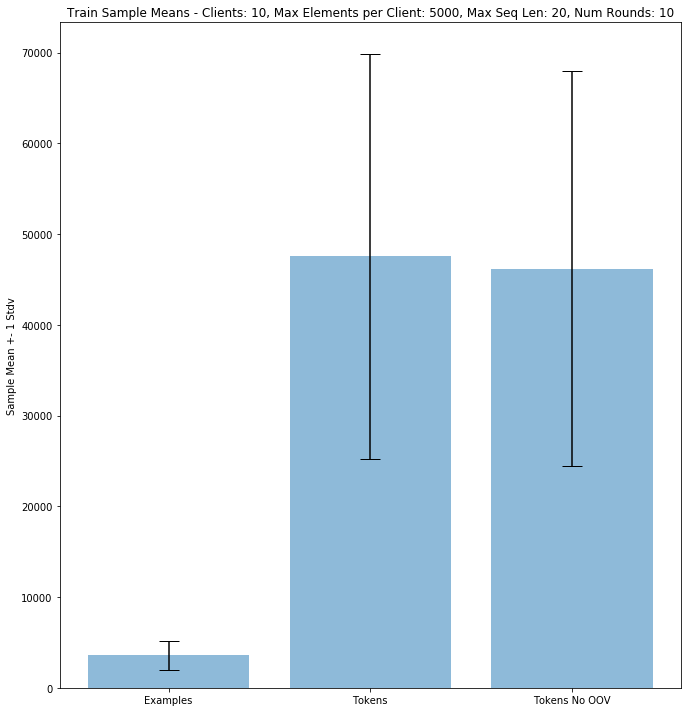

In [31]:
plt.clf()
fig, ax = plt.subplots(figsize=(10, 10))
x_pos = np.arange(len(train_sample_stats))
ax.bar(x_pos, means, yerr=stdvs, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Sample Mean +- 1 Stdv')
ax.set_xticks(x_pos)
ax.set_xticklabels(train_sample_stats)
ax.set_title('Train Sample Means - {}'.format(round_config))
plt.tight_layout()
plt.savefig(SAV + '{} Round Train Sample Means.png'.format(NUM_ROUNDS))
plt.show()

<Figure size 432x288 with 0 Axes>

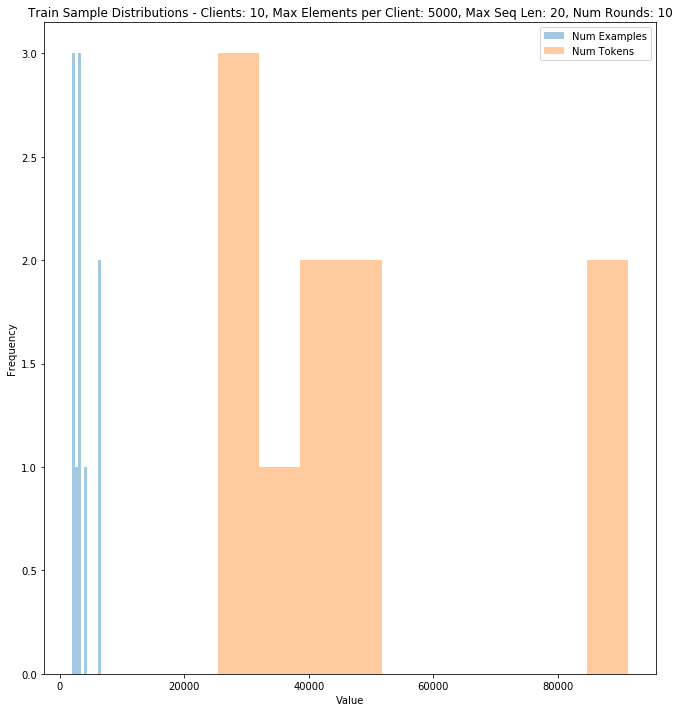

In [32]:
plt.clf()
fig, ax = plt.subplots(figsize=(10, 10))
plt.hist(examples, alpha=0.4, label='Num Examples')
plt.hist(tokens, alpha=0.4, label='Num Tokens')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Train Sample Distributions - {}'.format(round_config))
plt.legend(loc='best')
plt.tight_layout()
plt.savefig(SAV + '{} Round Train Sample Distributions.png'.format(NUM_ROUNDS))
plt.show()

<Figure size 432x288 with 0 Axes>

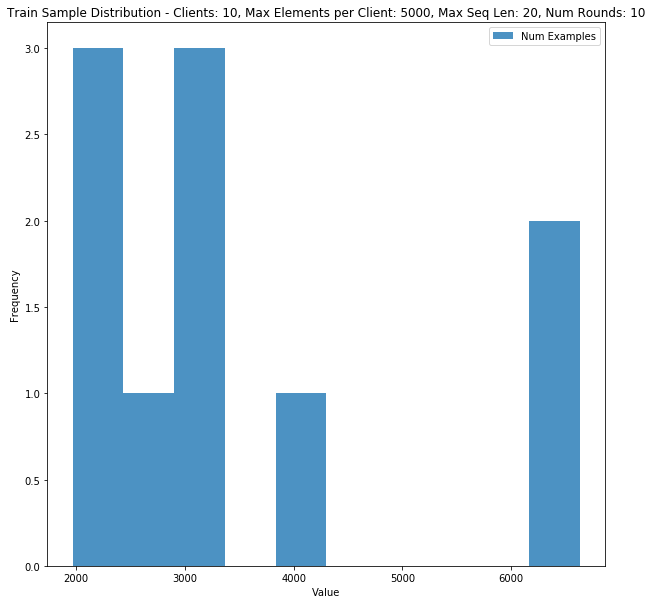

In [33]:
plt.clf()
fig, ax = plt.subplots(figsize=(10, 10))
plt.hist(examples, alpha=0.8, label='Num Examples')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Train Sample Distribution - {}'.format(round_config))
plt.legend(loc='best')
plt.show()

<Figure size 432x288 with 0 Axes>

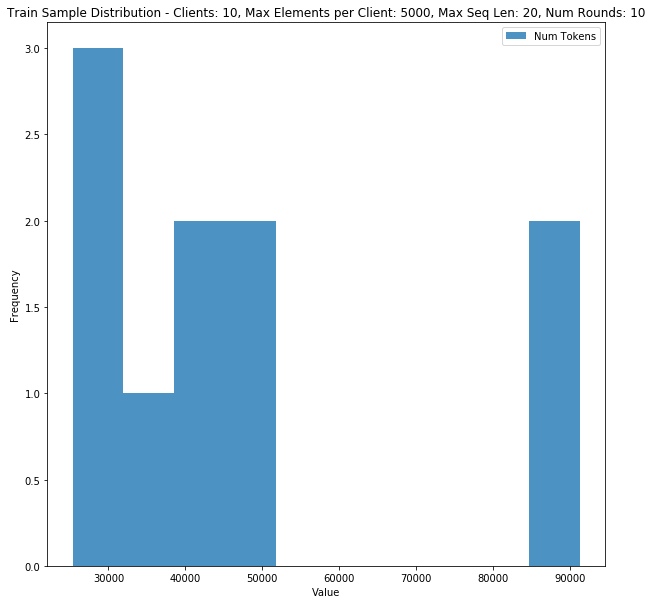

In [34]:
plt.clf()
fig, ax = plt.subplots(figsize=(10, 10))
plt.hist(tokens, alpha=0.8, label='Num Tokens')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Train Sample Distribution - {}'.format(round_config))
plt.legend(loc='best')
plt.show()

<Figure size 432x288 with 0 Axes>

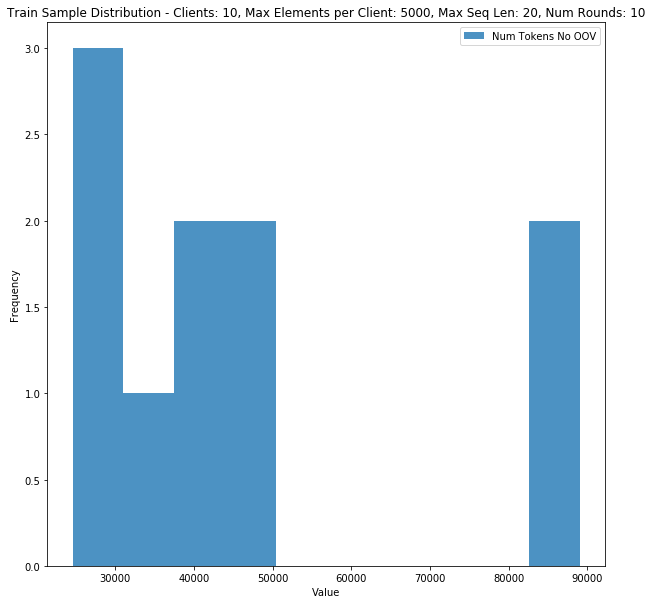

In [35]:
plt.clf()
fig, ax = plt.subplots(figsize=(10, 10))
plt.hist(tokens_no_oov, alpha=0.8, label='Num Tokens No OOV')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Train Sample Distribution - {}'.format(round_config))
plt.legend(loc='best')
plt.show()